# Rotten Tomatoes: Predict Sentiment (TextBlob-derived) from Movie Metadata
This version **does not use** the dataset's POSITIVE/NEGATIVE column as the target.

Instead:
1) We compute a **TextBlob polarity score** from `reviewText`.
2) We convert polarity to a binary label (POSITIVE/NEGATIVE) using a small neutral band.
3) We train a model to predict that TextBlob-derived sentiment using **other variables only** (movie metadata + selected non-text review metadata).

All outputs are saved to the `output/` folder.


In [17]:

# If you're running this in Jupyter, run this once if needed:
# !pip install pandas numpy scikit-learn matplotlib joblib textblob
#
# TextBlob may optionally need corpora for some features; sentiment polarity usually works without extra downloads.
# If you hit errors, uncomment the next two lines:
# import textblob
# !python -m textblob.download_corpora

import os
import re
from pathlib import Path
import pandas as pd
import numpy as np


In [18]:

# -----------------------------
# Paths + output folder
# -----------------------------
OUTPUT_DIR = Path("../output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def safe_filename(name: str) -> str:
    """Remove Windows-illegal characters and normalize spaces."""
    name = re.sub(r'[<>:"/\\|?*]', '', name)
    name = name.replace(" ", "_")
    return name

print("Working directory:", Path.cwd())
print("Output folder:", OUTPUT_DIR.resolve())


Working directory: c:\Users\chank\github\DataScienceProject1\scripts
Output folder: C:\Users\chank\github\DataScienceProject1\output


In [19]:

# -----------------------------
# Locate input files
# -----------------------------
# Preferred project layout:
#   ../data/rotten_tomatoes_movies.csv
#   ../data/rotten_tomatoes_movie_reviews.csv
#
# Fallback for this environment:
#   /mnt/data/rotten_tomatoes_movies.csv
#   /mnt/data/rotten_tomatoes_movie_reviews.csv

candidates = [
    (Path("../data/rotten_tomatoes_movies.csv"), Path("../data/rotten_tomatoes_movie_reviews.csv")),
    (Path("data/rotten_tomatoes_movies.csv"), Path("data/rotten_tomatoes_movie_reviews.csv")),
    (Path("/mnt/data/rotten_tomatoes_movies.csv"), Path("/mnt/data/rotten_tomatoes_movie_reviews.csv")),
]

movies_path = None
reviews_path = None
for m, r in candidates:
    if m.exists() and r.exists():
        movies_path, reviews_path = m, r
        break

if movies_path is None:
    raise FileNotFoundError(
        "Could not find the input CSVs. Put them in ../data/ or data/, or update the paths in this cell."
    )

print("Movies:", movies_path.resolve())
print("Reviews:", reviews_path.resolve())


Movies: C:\Users\chank\github\DataScienceProject1\data\rotten_tomatoes_movies.csv
Reviews: C:\Users\chank\github\DataScienceProject1\data\rotten_tomatoes_movie_reviews.csv


In [20]:

# -----------------------------
# Load data
# -----------------------------
movies = pd.read_csv(movies_path)
reviews = pd.read_csv(reviews_path)

print("movies shape:", movies.shape)
print("reviews shape:", reviews.shape)

display(movies.head(3))
display(reviews.head(3))


movies shape: (143258, 16)
reviews shape: (1444963, 11)


,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...


## Join reviews to movies
We join on `id` so each review inherits movie metadata.


In [21]:

df = reviews.merge(movies, on="id", how="inner")
print("Joined shape:", df.shape)
display(df.head(3))


Joined shape: (1469543, 26)


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,...,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,...,NaN,2011-06-21,30.0,Documentary,English,Stephen Low,NaN,NaN,NaN,NaN
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN


## TextBlob sentiment metric (polarity)
We compute **polarity** in [-1, 1] from `reviewText` using TextBlob.

**Tip:** This can be slow on large datasets. The cell caches results to `output/textblob_polarity.parquet` so you only compute once.


In [23]:

from textblob import TextBlob

cache_path = OUTPUT_DIR / "textblob_polarity.parquet"

if cache_path.exists():
    pol_df = pd.read_parquet(cache_path)
    if len(pol_df) == len(df) and "polarity" in pol_df.columns:
        df["polarity"] = pol_df["polarity"].values
        df["subjectivity"] = pol_df.get("subjectivity", pd.Series([np.nan]*len(df))).values
        print("Loaded cached polarity from:", cache_path.resolve())
    else:
        print("Cache exists but shape/columns don't match; recomputing.")
        cache_path.unlink(missing_ok=True)

if "polarity" not in df.columns:
    text = df["reviewText"].fillna("").astype(str)

    df["polarity"] = text.apply(lambda t: TextBlob(t).sentiment.polarity)
    df["subjectivity"] = text.apply(lambda t: TextBlob(t).sentiment.subjectivity)

    df[["polarity", "subjectivity"]].to_parquet(cache_path, index=False)
    print("Saved polarity cache to:", cache_path.resolve())

df[["reviewText", "polarity", "subjectivity"]].head(5)


,reviewText,polarity,subjectivity
0,Timed to be just long enough for most youngste...,0.190000,0.446667
1,It doesn't matter if a movie costs 300 million...,-0.130612,0.651020
2,The choreography is so precise and lifelike at...,0.235000,0.495000
3,The film's out-of-touch attempts at humor may ...,0.425000,0.616667
4,Its clumsy determination is endearing and some...,0.233333,0.533333


## Define target from polarity
We create a binary label with a **neutral band** around 0 to avoid ambiguous cases:
- polarity > +0.05 → POSITIVE
- polarity < −0.05 → NEGATIVE
- otherwise → NEUTRAL (dropped for binary modeling)


In [24]:

NEUTRAL_BAND = 0.05

df["tb_sentiment"] = np.where(df["polarity"] > NEUTRAL_BAND, "POSITIVE",
                       np.where(df["polarity"] < -NEUTRAL_BAND, "NEGATIVE", "NEUTRAL"))

print(df["tb_sentiment"].value_counts())

df_bin = df[df["tb_sentiment"].isin(["POSITIVE", "NEGATIVE"])].copy()
print("Binary dataset shape:", df_bin.shape)
print(df_bin["tb_sentiment"].value_counts(normalize=True))


tb_sentiment
POSITIVE    832349
NEUTRAL     376812
NEGATIVE    260382
Name: count, dtype: int64
Binary dataset shape: (1092731, 29)
tb_sentiment
POSITIVE    0.761714
NEGATIVE    0.238286
Name: proportion, dtype: float64


## Build features (exclude POSITIVE/NEGATIVE column from dataset)
We **do not** use the dataset's `scoreSentiment` column.
We also **exclude** the text itself (`reviewText`) from features.


In [25]:

df_bin["creationDate"] = pd.to_datetime(df_bin["creationDate"], errors="coerce")
df_bin["review_year"] = df_bin["creationDate"].dt.year
df_bin["review_month"] = df_bin["creationDate"].dt.month

y = df_bin["tb_sentiment"]

drop_cols = [
    "tb_sentiment",
    "polarity", "subjectivity",
    "scoreSentiment",
    "reviewText", "reviewUrl",
    "criticName", "publicationName",
    "creationDate",
    "reviewId"
]

X = df_bin.drop(columns=[c for c in drop_cols if c in df_bin.columns]).copy()

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())
display(X.head(3))


X shape: (1092731, 22)
y distribution:
 tb_sentiment
POSITIVE    832349
NEGATIVE    260382
Name: count, dtype: int64


,id,isTopCritic,originalScore,reviewState,publicatioName,title,audienceScore,tomatoMeter,rating,ratingContents,...,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,review_year,review_month
0,beavers,False,3.5/4,fresh,Deseret News (Salt Lake City),Beavers,75.0,NaN,NaN,NaN,...,30.0,Documentary,English,Stephen Low,NaN,NaN,NaN,NaN,2003,5
1,blood_mask,False,1/5,rotten,Dread Central,Blood Mask,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN,2007,6
2,city_hunter_shinjuku_private_eyes,False,NaN,fresh,CBR,City Hunter: Shinjuku Private Eyes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN,2019,5


## Train/test split + model pipeline
Baseline model: **Logistic Regression** with one-hot encoding for categorical variables.


In [26]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import joblib


In [27]:

numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (874184, 22) Test: (218547, 22)


In [28]:

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label="POSITIVE")

print(f"Accuracy: {acc:.4f}")
print(f"F1 (POSITIVE): {f1:.4f}")


c:\Users\chank\github\DataScienceProject1\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6861
F1 (POSITIVE): 0.7775


In [29]:

report = classification_report(y_test, y_pred)
print(report)

report_path = OUTPUT_DIR / "textblob_target_classification_report.txt"
report_path.write_text(report, encoding="utf-8")
print("Saved:", report_path.resolve())


              precision    recall  f1-score   support

    NEGATIVE       0.39      0.58      0.47     52077
    POSITIVE       0.85      0.72      0.78    166470

    accuracy                           0.69    218547
   macro avg       0.62      0.65      0.62    218547
weighted avg       0.74      0.69      0.70    218547

Saved: C:\Users\chank\github\DataScienceProject1\output\textblob_target_classification_report.txt


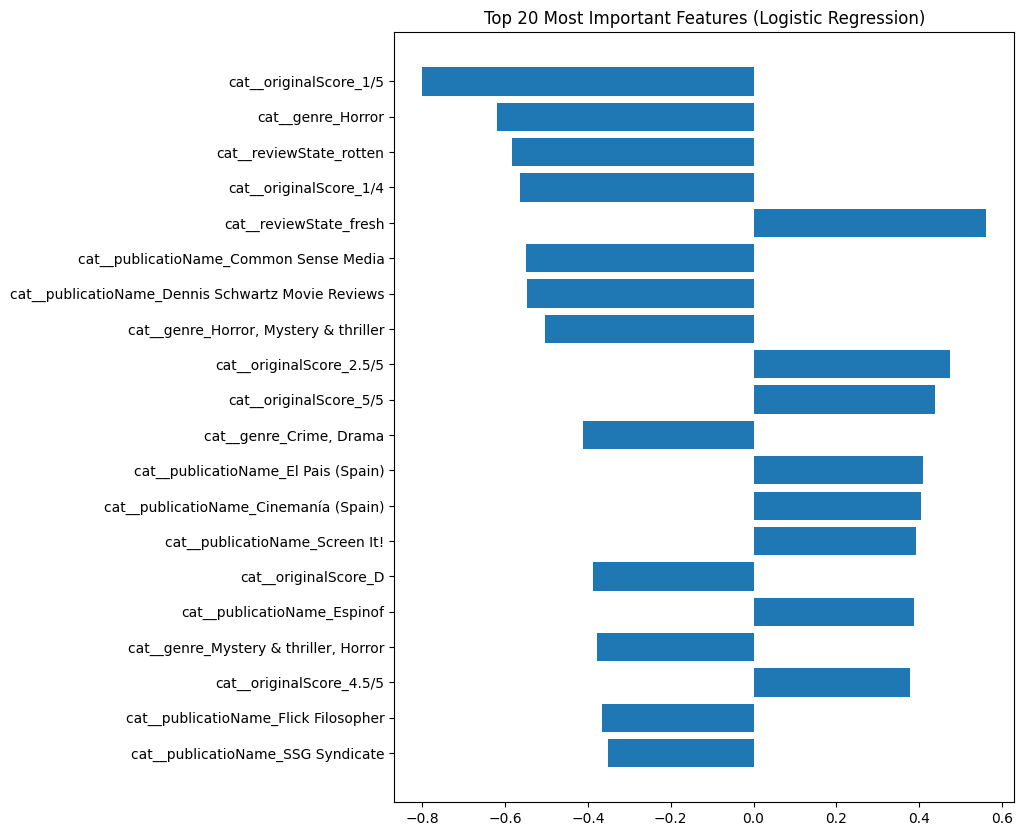

In [34]:
# Get fitted pipeline
model = clf  # or whatever your pipeline variable is called

# Get preprocessing step
preprocess = model.named_steps["preprocess"]

# Get feature names after transformation
feature_names = preprocess.get_feature_names_out()

coefs = model.named_steps["model"].coef_[0]


importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
})

importance_df = importance_df.sort_values("abs_coefficient", ascending=False)

importance_df.head(20)


top_n = 20
top_features = importance_df.head(top_n)



plt.figure(figsize=(8, 10))
plt.barh(top_features["feature"], top_features["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (Logistic Regression)")
plot_name = safe_filename("top_20_features.png")
plt.savefig(OUTPUT_DIR / plot_name, bbox_inches="tight")
plt.show()





In [31]:

cm = confusion_matrix(y_test, y_pred, labels=["NEGATIVE", "POSITIVE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])

plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (TextBlob target, Logistic Regression)")
plot_name = safe_filename("confusion_matrix_textblob_target_logistic_regression.png")
plt.savefig(OUTPUT_DIR / plot_name, bbox_inches="tight")
plt.close()

print("Saved:", (OUTPUT_DIR / plot_name).resolve())


Saved: C:\Users\chank\github\DataScienceProject1\output\confusion_matrix_textblob_target_logistic_regression.png


<Figure size 640x480 with 0 Axes>

## Save trained pipeline

In [32]:

model_path = OUTPUT_DIR / "movie_sentiment_from_metadata_textblob_target.joblib"
joblib.dump(clf, model_path)
print("Saved model:", model_path.resolve())


Saved model: C:\Users\chank\github\DataScienceProject1\output\movie_sentiment_from_metadata_textblob_target.joblib


## Diagnostic only: Compare TextBlob label vs Rotten Tomatoes scoreSentiment
This is **not used** for training; it helps you sanity-check how TextBlob aligns with the dataset's label.


In [33]:

if "scoreSentiment" in df_bin.columns:
    valid = df_bin["scoreSentiment"].isin(["POSITIVE", "NEGATIVE"])
    if valid.any():
        comp = df_bin.loc[valid, ["scoreSentiment", "tb_sentiment"]].copy()
        comp["match"] = comp["scoreSentiment"] == comp["tb_sentiment"]
        match_rate = comp["match"].mean()
        print(f"TextBlob vs scoreSentiment match rate: {match_rate:.3f} (diagnostic)")
        comp.to_csv(OUTPUT_DIR / "textblob_vs_scoresentiment_comparison.csv", index=False)
        print("Saved comparison CSV to output/")


TextBlob vs scoreSentiment match rate: 0.704 (diagnostic)
Saved comparison CSV to output/
